# Trucks Traffic on King Fahd Bridge – Data Analysis

In this section, we work only with the data related to **trucks traffic on King Fahd Bridge**.
We will:

- Load the annual and quarterly Excel files.
- Clean and standardize column names.
- Combine them into one tidy DataFrame.
- Compute simple statistics and percentage changes.
- Build time series summaries.
- Plot basic trends for trucks and passengers.

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl

In [2]:
# Import basic libraries

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Make sure plots show nicely inside the notebook
%matplotlib inline

## Set file paths for the King Fahd Bridge truck datasets

Here we set up paths to the Excel files related to truck traffic.

Assumption:
- All the Excel files are stored in the `data_raw/` folder of the repository.
- We only use the valid files (annual data + Q2, Q3, Q4 2024 + Q3 2025).

In [3]:
from pathlib import Path

# Folder that contains the truck traffic Excel files
DATA_DIR = Path("..") / "Data" / "truck_traffic"

# Check what Excel files are available in this folder
list(DATA_DIR.glob("*.xlsx"))

[WindowsPath('../Data/truck_traffic/Trucks traffic on King Fahad bridge Excel.xlsx'),
 WindowsPath('../Data/truck_traffic/Trucks Traffic on King Fahad Bridge Q2 2025.xlsx'),
 WindowsPath('../Data/truck_traffic/Trucks Traffic on King Fahad Bridge Q3 2025 xlsx.xlsx'),
 WindowsPath('../Data/truck_traffic/Trucks traffic on King Fahd bridge Q1 2024.xlsx'),
 WindowsPath('../Data/truck_traffic/Trucks traffic on King Fahd bridge Q1 2025.xlsx'),
 WindowsPath('../Data/truck_traffic/Trucks traffic on King Fahd bridge Q2 2024.xlsx'),
 WindowsPath('../Data/truck_traffic/Trucks traffic on King Fahd bridge Q3 2024.xlsx'),
 WindowsPath('../Data/truck_traffic/Trucks traffic on King Fahd bridge Q4 2024.xlsx')]

In [4]:
# Base folder for raw data
DATA_DIR = Path("..") / "Data" / "truck_traffic"

# File names for this dataset (adjust if you rename them in the repo)
annual_file = DATA_DIR / "Trucks traffic on King Fahad bridge Excel.xlsx"
q2_2024_file = DATA_DIR / "Trucks traffic on King Fahd bridge Q2 2024.xlsx"
q3_2024_file = DATA_DIR / "Trucks traffic on King Fahd bridge Q3 2024.xlsx"
q4_2024_file = DATA_DIR / "Trucks traffic on King Fahd bridge Q4 2024.xlsx"
q3_2025_file = DATA_DIR / "Trucks Traffic on King Fahad Bridge Q3 2025 xlsx.xlsx"


## Load each Excel file separately

In this step, we load:
- Annual data (2019–2023).
- Quarterly data for 2024 (Q2, Q3, Q4).
- Quarterly data for 2025 (Q3).

We use the `openpyxl` engine to read `.xlsx` files.

In [5]:
# Load each dataset
annual_df = pd.read_excel(annual_file, engine="openpyxl")
q2_2024_df = pd.read_excel(q2_2024_file, engine="openpyxl")
q3_2024_df = pd.read_excel(q3_2024_file, engine="openpyxl")
q4_2024_df = pd.read_excel(q4_2024_file, engine="openpyxl")
q3_2025_df = pd.read_excel(q3_2025_file, engine="openpyxl")

# Display the first few rows of each dataframe to verify loading
annual_df.head(), q2_2024_df.head(), q3_2024_df.head(), q4_2024_df.head(), q3_2025_df.head()

(   السنة         المنفذ الاتجاه  عدد الشاحنات  عدد الركاب
 0   2019  جسر الملك فهد    قدوم        195309      216352
 1   2019  جسر الملك فهد  مغادرة        184189      184915
 2   2020  جسر الملك فهد    قدوم        166313      171677
 3   2020  جسر الملك فهد  مغادرة        157533      157728
 4   2021  جسر الملك فهد    قدوم        178856      170906,
    السنة         المنفذ الاتجاه  عدد الشاحنات  عدد الركاب
 0   2024  جسر الملك فهد    قدوم         48984       47616
 1   2024  جسر الملك فهد  مغادرة         43844       43414,
    السنة         المنفذ الاتجاه  عدد الشاحنات  عدد الركاب
 0   2024  جسر الملك فهد    قدوم         56106       54234
 1   2024  جسر الملك فهد  مغادرة         46871       46236,
    السنة         الجمرك اتجاه الحركة  عدد الشاحنات  عدد الركاب
 0   2024  جسر الملك فهد         قدوم         73836       71586
 1   2024  جسر الملك فهد       مغادرة         52238       52134,
    السنة         الجمرك اتجاه الحركة  عدد الشاحنات  عدد الركاب الربع
 0   2025  جسر الملك فهد  

## Standardize column names

Column names are in Arabic and slightly different between files.

Here we:
- Rename all columns to a common English set.
- This makes later steps (groupby, plots) easier.

We keep:
- `year`
- `port`
- `direction`
- `trucks`
- `passengers`
- `quarter` (for quarterly data)

In [6]:
# Helper function to standardize column names
def standardize_columns(df):
    return df.rename(columns={
        "السنة": "year",
        "المنفذ": "port",
        "الجمرك": "port",
        "الاتجاه": "direction",
        "اتجاه الحركة": "direction",
        "عدد الشاحنات": "trucks",
        "عدد الركاب": "passengers",
        "الربع": "quarter"
    })

annual_df = standardize_columns(annual_df)
q2_2024_df = standardize_columns(q2_2024_df)
q3_2024_df = standardize_columns(q3_2024_df)
q4_2024_df = standardize_columns(q4_2024_df)
q3_2025_df = standardize_columns(q3_2025_df)

annual_df.head()

,year,port,direction,trucks,passengers
0,2019,جسر الملك فهد,قدوم,195309,216352
1,2019,جسر الملك فهد,مغادرة,184189,184915
2,2020,جسر الملك فهد,قدوم,166313,171677
3,2020,جسر الملك فهد,مغادرة,157533,157728
4,2021,جسر الملك فهد,قدوم,178856,170906


## Add period type and quarter information

We now:
- Mark annual data with `period_type = "annual"`.
- Mark quarterly data with `period_type = "quarterly"`.
- Add `quarter` values for 2024 files (Q2, Q3, Q4) based on the file names.

In [7]:
# Annual data: 2019–2023
annual_df["period_type"] = "annual"
annual_df["quarter"] = None

# Quarterly data: 2024
q2_2024_df["period_type"] = "quarterly"
q2_2024_df["quarter"] = "Q2"

q3_2024_df["period_type"] = "quarterly"
q3_2024_df["quarter"] = "Q3"

q4_2024_df["period_type"] = "quarterly"
q4_2024_df["quarter"] = "Q4"

# Quarterly data: 2025 (Q3 already has year, we keep quarter column as is)
q3_2025_df["period_type"] = "quarterly"
q3_2025_df["quarter"] = q3_2025_df.get("quarter", "Q3")  # if missing, set to Q3

q3_2025_df.head()

,year,port,direction,trucks,passengers,quarter,period_type
0,2025,جسر الملك فهد,قدوم,75069,72909,Q3,quarterly
1,2025,جسر الملك فهد,مغادرة,52552,52296,Q3,quarterly


## Combine all truck traffic data into one DataFrame

Here we stack all the standardized tables into a single table:

- Each row = a combination of:
  - year
  - port
  - direction (arrival or departure)
  - period type (annual or quarterly)
  - quarter (if applicable)
  - trucks and passengers counts

This makes it easier to compute summaries and time series.

In [8]:
combined_df = pd.concat(
    [annual_df, q2_2024_df, q3_2024_df, q4_2024_df, q3_2025_df],
    ignore_index=True
)

combined_df.head()

,year,port,direction,trucks,passengers,period_type,quarter
0,2019,جسر الملك فهد,قدوم,195309,216352,annual,None
1,2019,جسر الملك فهد,مغادرة,184189,184915,annual,None
2,2020,جسر الملك فهد,قدوم,166313,171677,annual,None
3,2020,جسر الملك فهد,مغادرة,157533,157728,annual,None
4,2021,جسر الملك فهد,قدوم,178856,170906,annual,None


## Basic data checks

We now:
- Check the number of rows.
- Look at missing values.
- Confirm the unique values for year, period_type, direction, and quarter.

This helps us confirm that the data looks reasonable before deeper analysis.

In [9]:
print("Shape:", combined_df.shape)
print("\nMissing values per column:")
print(combined_df.isna().sum())

print("\nUnique years:", combined_df["year"].unique())
print("Unique period types:", combined_df["period_type"].unique())
print("Unique directions:", combined_df["direction"].unique())
print("Unique quarters:", combined_df["quarter"].unique())

Shape: (18, 7)

Missing values per column:
year            0
port            0
direction       0
trucks          0
passengers      0
period_type     0
quarter        10
dtype: int64

Unique years: [2019 2020 2021 2022 2023 2024 2025]
Unique period types: ['annual' 'quarterly']
Unique directions: ['قدوم' 'مغادرة']
Unique quarters: [None 'Q2' 'Q3' 'Q4']


## Annual totals and year-on-year % changes (2019–2023)

In this step we:
- Focus on **annual** data.
- Sum trucks and passengers per year (both directions together).
- Compute year-on-year percentage change:
  - How much did total trucks change compared to the previous year?
  - How much did total passengers change?

This gives a simple view of growth or decline over time.

In [10]:
annual_only = combined_df[combined_df["period_type"] == "annual"].copy()

annual_summary = (
    annual_only
    .groupby("year", as_index=False)
    .agg(
        total_trucks=("trucks", "sum"),
        total_passengers=("passengers", "sum")
    )
)

annual_summary["trucks_yoy_pct"] = annual_summary["total_trucks"].pct_change() * 100
annual_summary["passengers_yoy_pct"] = annual_summary["total_passengers"].pct_change() * 100

annual_summary

,year,total_trucks,total_passengers,trucks_yoy_pct,passengers_yoy_pct
0,2019,379498,401267,NaN,NaN
1,2020,323846,329405,-14.664636,-17.908774
2,2021,349002,340189,7.767890,3.273782
3,2022,360486,354226,3.290526,4.126236
4,2023,377506,372681,4.721404,5.209951


## Arrival vs departure shares (percentages)

Here we look at the **balance between arrivals and departures**.

We:
- Group by year (for annual data).
- Calculate:
  - Total trucks per year.
  - Percentage of trucks that are arrivals.
  - Percentage of passengers that are arrivals.

This tells us if flows are balanced or if one direction dominates.

In [11]:
def arrival_share_percent(df, group_cols):
    grouped = df.groupby(group_cols)
    result = []

    for keys, g in grouped:
        total_trucks = g["trucks"].sum()
        total_passengers = g["passengers"].sum()

        arrival_trucks = g.loc[g["direction"] == "قدوم", "trucks"].sum()
        arrival_passengers = g.loc[g["direction"] == "قدوم", "passengers"].sum()

        row = dict(zip(group_cols, keys if isinstance(keys, tuple) else (keys,)))
        row.update({
            "total_trucks": total_trucks,
            "arrival_trucks_pct": (arrival_trucks / total_trucks) * 100 if total_trucks else None,
            "arrival_passengers_pct": (arrival_passengers / total_passengers) * 100 if total_passengers else None,
        })
        result.append(row)

    return pd.DataFrame(result)

# Annual arrival vs departure shares
arrival_annual = arrival_share_percent(annual_only, ["year"])
arrival_annual

,year,total_trucks,arrival_trucks_pct,arrival_passengers_pct
0,2019,379498,51.465093,53.917217
1,2020,323846,51.355583,52.117302
2,2021,349002,51.247844,50.238544
3,2022,360486,50.859118,50.422612
4,2023,377506,50.731644,50.143957


## Quarterly summaries for 2024–2025

Now we focus on **quarterly data**.

We:
- Group by year and quarter.
- Sum trucks and passengers.
- This gives us a simple time series by quarter.

Later, we can compare Q3 2024 vs Q3 2025 to see growth.

In [12]:
quarterly_only = combined_df[combined_df["period_type"] == "quarterly"].copy()

quarterly_summary = (
    quarterly_only
    .groupby(["year", "quarter"], as_index=False)
    .agg(
        total_trucks=("trucks", "sum"),
        total_passengers=("passengers", "sum")
    )
    .sort_values(["year", "quarter"])
)

quarterly_summary

,year,quarter,total_trucks,total_passengers
0,2024,Q2,92828,91030
1,2024,Q3,102977,100470
2,2024,Q4,126074,123720
3,2025,Q3,127621,125205


## Quarterly arrival vs departure shares

Here we extend the previous idea to the quarterly level.

We:
- Group by year and quarter.
- Compute arrival vs departure shares for trucks and passengers.
- This shows how the direction balance behaves within each quarter.

In [13]:
arrival_quarterly = arrival_share_percent(quarterly_only, ["year", "quarter"])
arrival_quarterly.sort_values(["year", "quarter"])

,year,quarter,total_trucks,arrival_trucks_pct,arrival_passengers_pct
0,2024,Q2,92828,52.768561,52.308030
1,2024,Q3,102977,54.484011,53.980293
2,2024,Q4,126074,58.565604,57.861300
3,2025,Q3,127621,58.821824,58.231700


## Plot: Annual trucks and passengers (2019–2023)

We now plot annual totals:

- X-axis: year.
- Y-axis: number of trucks / passengers.

This gives a quick visual of the COVID dip and the recovery after 2020.

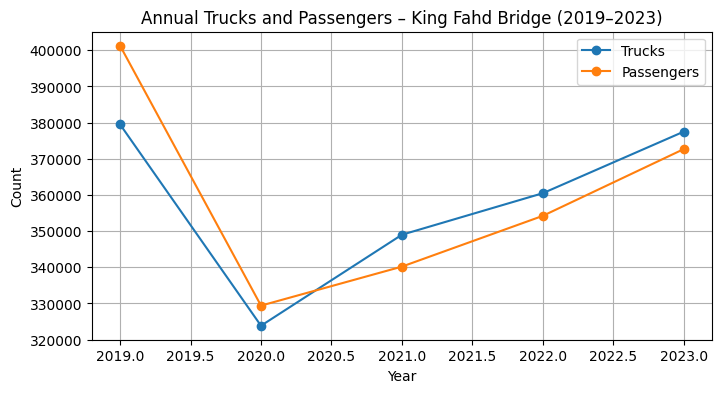

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(annual_summary["year"], annual_summary["total_trucks"], marker="o", label="Trucks")
plt.plot(annual_summary["year"], annual_summary["total_passengers"], marker="o", label="Passengers")
plt.title("Annual Trucks and Passengers – King Fahd Bridge (2019–2023)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

## Plot: Quarterly trucks for latest periods (2024–2025)

Here we visualize the quarterly totals:

- We show total trucks by (year, quarter).
- This helps us see the increase in traffic over quarters and between years.

Note: We only have Q2–Q4 for 2024 and Q3 for 2025.

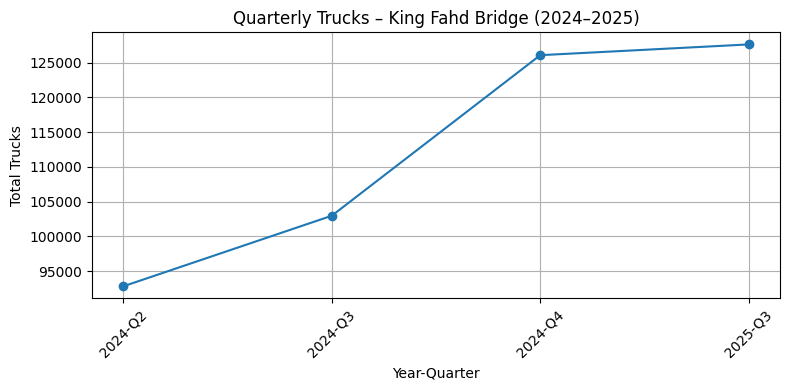

In [15]:
# Create a simple label like "2024-Q2", "2024-Q3", ...
quarterly_summary["year_quarter"] = (
    quarterly_summary["year"].astype(str) + "-" + quarterly_summary["quarter"]
)

plt.figure(figsize=(8, 4))
plt.plot(quarterly_summary["year_quarter"], quarterly_summary["total_trucks"], marker="o")
plt.title("Quarterly Trucks – King Fahd Bridge (2024–2025)")
plt.xlabel("Year-Quarter")
plt.ylabel("Total Trucks")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot: Arrival share of trucks by year (annual data)

Finally, we visualize how balanced arrivals and departures are over time.

- Y-axis shows the percentage of trucks that are arrivals.
- A value near 50% means arrivals and departures are almost balanced.

This helps us check if there is any strong directional bias over the years.

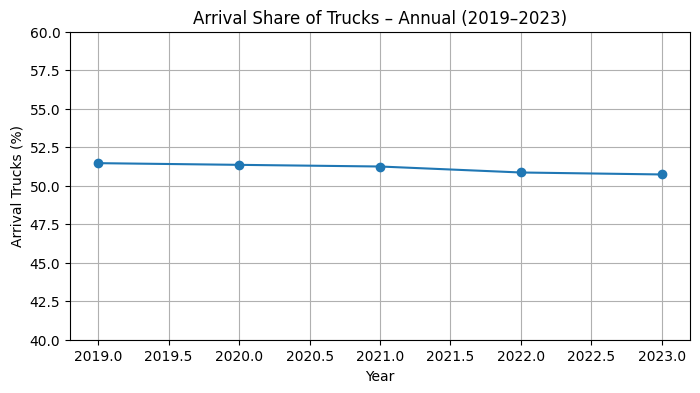

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(arrival_annual["year"], arrival_annual["arrival_trucks_pct"], marker="o")
plt.title("Arrival Share of Trucks – Annual (2019–2023)")
plt.xlabel("Year")
plt.ylabel("Arrival Trucks (%)")
plt.ylim(40, 60)
plt.grid(True)
plt.show()